In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
# pip install geopandas
import geopandas as gpd
from shapely.geometry import Polygon
import os

# Read GeoJSON file into a GeoDataFrame
parent_directory = os.path.dirname(os.getcwd())
file_path = parent_directory + '/data/Existing_Bike_Network_2023.geojson'

bike_lanes = gpd.read_file(file_path)
bike_lanes['year'] = pd.to_numeric(bike_lanes['InstallDat'], errors = 'coerce').astype('Int64')


In [6]:
infra_dict = {'BFBL' : 'Buffered bike lane',
'BL' : 'Bike lane',
'BLSL' : 'Bike lane on one side, shared lane on the opposite side',
'BSBL' : 'Bus/bike lane',
'CFBL' : 'Contra-flow bike street',
'NSUP' : 'Shared use path, natural surface',
'NW' : 'Neighborway, marked',
'NW-U' : 'Neighborway, unmarked',
'SBL' : 'Separated bike lane',
'SBLBL' : 'Separated bike lane on one side, bike lane on the opposite side',
'SLM' : 'Shared lane markings',
'SLMTC' : 'Shared lane markings, Traffic calmed street',
'SRd' : 'Shared road',
'SUB' : 'Shared use path bridge',
'SUC' : 'Shared use connector',
'SUP' : 'Shared use path',
'TC' : 'Traffic calmed street',
}
bike_lanes['ExisFacil'].replace(infra_dict, inplace=True) # remove later

##### Dorchester

In [7]:
# Define the coordinates of the polygon (clockwise or counterclockwise order)
# Repeat the first point to close the polygon
# coords are written (long, lat), reversed from map data 
dorchester = [(-71.09631340189638, 42.29181136750529), ( -71.06352608002106, 42.33065605689039), ( -71.03297035596972, 42.3165681070428),
                   ( -71.05391304324087,42.30768219241062), ( -71.03760521298875, 42.28838274399551), (-71.07176582583267, 42.27834977370352),
                    ( -71.09631340189638, 42.29181136750529) ] 

# Create a Polygon object from the coordinates
dorchester_poly = Polygon(dorchester)
dorchester_gdf = bike_lanes[bike_lanes.geometry.within(dorchester_poly)]


In [8]:
# Streets with most bike lanes
street_df = dorchester_gdf.loc[dorchester_gdf['STREET_NAM']!=' ']
total_length_df = street_df.groupby(['STREET_NAM'])['Shape_Leng'].sum().reset_index()
total_length_df.rename(columns={'Shape_Leng': 'Total_Length'}, inplace=True)
total_length_df.sort_values(by='Total_Length',ascending=False,inplace=True)
top_5_streets = total_length_df.head(5)
top_5_streets.STREET_NAM.to_list()

['Columbia Road',
 'Dorchester Avenue',
 'Blue Hill Avenue',
 'Talbot Avenue',
 'American Legion Highway']

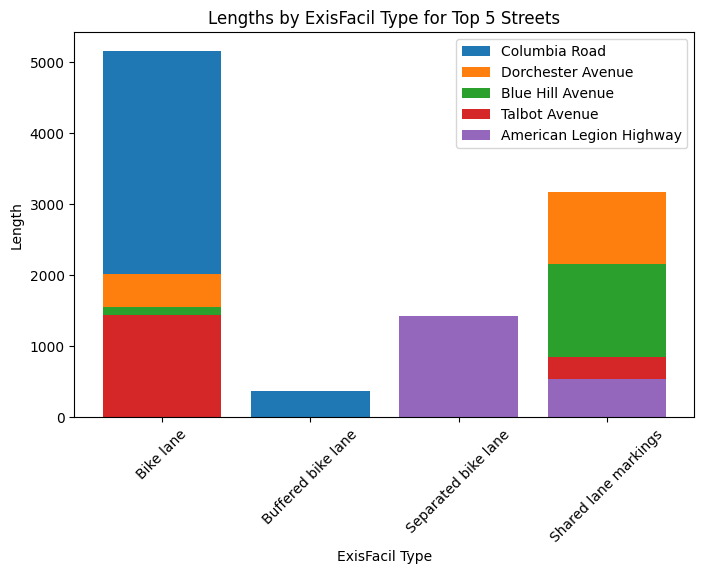

In [9]:
# length by street, for each facility type

data_dict = {}

for street in top_5_streets['STREET_NAM']:
    street_data = street_df.loc[street_df['STREET_NAM'] == street]
    lengths_by_type = street_data.groupby('ExisFacil')['Shape_Leng'].sum().reset_index()
    data_dict[street] = dict(zip(lengths_by_type['ExisFacil'], lengths_by_type['Shape_Leng']))

# Create a single plot with each street on the x-axis and different facility types as bars
plt.figure(figsize=(8, 5))
for street, data in data_dict.items():
    plt.bar(data.keys(), data.values(), label=street)

plt.xlabel('ExisFacil Type')
plt.ylabel('Length')
plt.title('Lengths by ExisFacil Type for Top 5 Streets')
plt.xticks(rotation=45)
plt.legend()
plt.show()


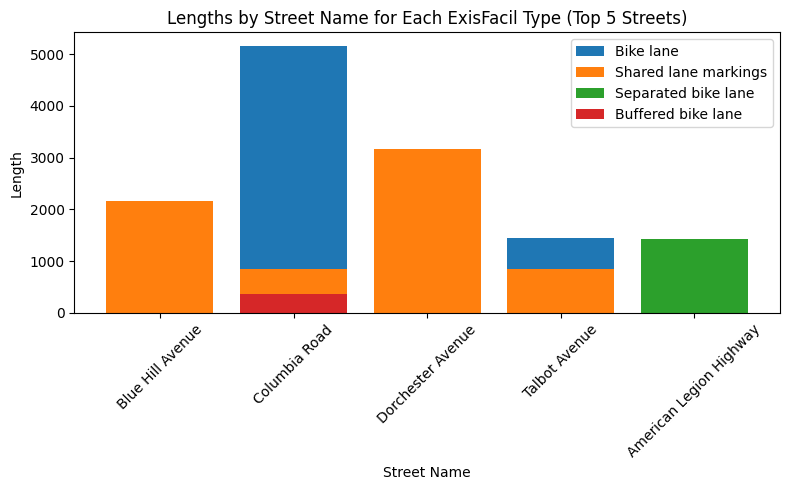

In [10]:
# length by facility type, for each street
data_dict = {}
color_dict = {}
# Populate the dictionary with lengths by Street name for each facility type for the top 5 streets
for facility_type in street_df['ExisFacil'].unique():
    facility_data = street_df.loc[(street_df['ExisFacil'] == facility_type) & (street_df['STREET_NAM'].isin(top_5_streets['STREET_NAM'].tolist()))]
    lengths_by_street = facility_data.groupby('STREET_NAM')['Shape_Leng'].sum().reset_index()
    data_dict[facility_type] = dict(zip(lengths_by_street['STREET_NAM'], lengths_by_street['Shape_Leng']))

unique_facility_types = data_dict.keys()
plt.figure(figsize=(8, 5))
for facility_type, data in data_dict.items():
    # color = color_dict[facility_type]  # Get color for the current facility type
    if data:
        plt.bar(data.keys(), data.values(), label=facility_type)

plt.xlabel('Street Name')
plt.ylabel('Length')
plt.title('Lengths by Street Name for Each ExisFacil Type (Top 5 Streets)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

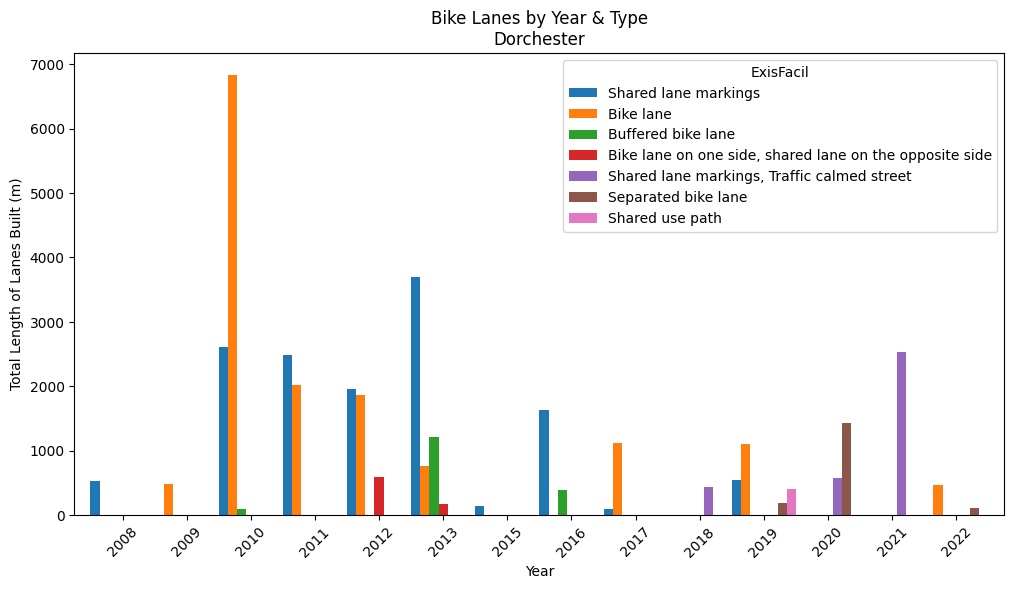

In [11]:
# total m of lanes by year and type
yealy_new_lanes = dorchester_gdf.groupby(['year', 'ExisFacil'])['Shape_Leng'].sum().unstack()
fig, ax = plt.subplots(figsize=(12, 6))
yealy_new_lanes.plot(kind='bar', ax=ax, align='center', width=1)
ax.set_xlabel('Year')
ax.set_ylabel('Total Length of Lanes Built (m)')
ax.set_title('Bike Lanes by Year & Type\nDorchester')
ax.tick_params(axis='x', rotation=45)
plt.show()